# Machine Learning - Supervised Techniques - Final Assignment

## Gábor Bagoly - OOHQ3E

### About the project
I've made a image classification project based on fruits. I choose this, since I wanted to learn more fruits that I could try out later in life, so came the idea of classifying 100 types of fruits that I've yet to know most of them.
This dataset came from Kaggle. I've been working on this project locally on my laptop as well as on Kaggle's own notebook, since they have the option of using more powerful TPU and GPU, which is essential to train an image classification model way faster compared to training it on a CPU, since the GPUs are better at matrix operations.
The dataset contains a train, test, and validation data, each separated into each category as well inside it.

Here is the link for the dataset: <https://www.kaggle.com/datasets/marquis03/fruits-100>

There was a problem during my work, which was that inside the validation folder - while in the train and test folder, the categories of the folders were named based on the category - the validation folder had the categories based on numbers, and for example the 01 folder was the 28th label based on the label list. And also they have a csv file for each set which would have had the labels for each picture file and their path. Here came the other problem, where the inside the validation.csv, the label for each picture is -1, so I made a simple adjustment of manually renaming each category folder to their corresponding category, so I could continue my work.

Another mind boggling problem was while working on the project, was that while on the Kaggle notebook and with GPU had a way faster training time, on my local machine it was way slower, however it achieved better results with the validation loss and the validation accuracy. So it was a bit of difficult situation of having the exact same codebase with different result. But in the end there came some (in my opinion) satisfactory results for the validation losses and the validation accuracies.

In [1]:
import numpy as np 
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import keras
from keras.utils import image_dataset_from_directory, split_dataset, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import models, layers, optimizers, Sequential
from keras.models import load_model
from keras.applications import ResNet50
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

The ```os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"``` 
line was necessary since keras and matplotlib had incompatibility issues on my local machine, and it fixed it.

Here I am preparing to load the data with giving the path for each set (train, test, and validation) as well as the file for the labels, as well as the image size of each picture to be 128x128 pixels.

In [2]:
base_directory = "./data"
test_data = (f"{base_directory}/test")
train_data = (f"{base_directory}/train")
val_data = (f"{base_directory}/val")
labels_filename = (f"{base_directory}/val/classname.txt")
image_size = (128, 128)

Down here I am using a keras util called image_dataset_from_directory which loads each picture in and after that as you can see, it wrote out that it found 40000 of training pictures, and 5000 pictures each for validation and test dataset.

In [3]:
train = image_dataset_from_directory(train_data, image_size=image_size)
validation = image_dataset_from_directory(val_data, image_size=image_size)
test = image_dataset_from_directory(test_data, image_size=image_size)

Found 40000 files belonging to 100 classes.
Found 5000 files belonging to 100 classes.
Found 5000 files belonging to 100 classes.


Down here I am loading the content of the classname.txt into a variable called labels, so I can use it later, and also write out the number of labels and everything that it has, so I can make sure that it is loaded correctly.

In [20]:
with open(labels_filename, 'r') as file:
    labels = file.read().splitlines()
    
print(f"Number of labels:{len(labels)}")
labels.sort()
print(labels)

Number of labels:100
['abiu', 'acai', 'acerola', 'ackee', 'ambarella', 'apple', 'apricot', 'avocado', 'banana', 'barbadine', 'barberry', 'betel_nut', 'bitter_gourd', 'black_berry', 'black_mullberry', 'brazil_nut', 'camu_camu', 'cashew', 'cempedak', 'chenet', 'cherimoya', 'chico', 'chokeberry', 'cluster_fig', 'coconut', 'corn_kernel', 'cranberry', 'cupuacu', 'custard_apple', 'damson', 'dewberry', 'dragonfruit', 'durian', 'eggplant', 'elderberry', 'emblic', 'feijoa', 'fig', 'finger_lime', 'gooseberry', 'goumi', 'grape', 'grapefruit', 'greengage', 'grenadilla', 'guava', 'hard_kiwi', 'hawthorn', 'hog_plum', 'horned_melon', 'indian_strawberry', 'jaboticaba', 'jackfruit', 'jalapeno', 'jamaica_cherry', 'jambul', 'jocote', 'jujube', 'kaffir_lime', 'kumquat', 'lablab', 'langsat', 'longan', 'mabolo', 'malay_apple', 'mandarine', 'mango', 'mangosteen', 'medlar', 'mock_strawberry', 'morinda', 'mountain_soursop', 'oil_palm', 'olive', 'otaheite_apple', 'papaya', 'passion_fruit', 'pawpaw', 'pea', 'pin

Down here I am making some helper variables, so I can visualize and also make sure that the distribution of each set is good for this project, since it's not good if for example a category has the majority of the pictures while the other categories lack the pictures for traing.

In [6]:
train_and_counts = {label: len(os.listdir(os.path.join(train_data, label))) for label in labels}
valid_and_counts = {label: len(os.listdir(os.path.join(val_data, label))) for label in labels}
test_and_counts =  {label: len(os.listdir(os.path.join(test_data, label))) for label in labels}

print(f"Number of train classes:{len(train_and_counts)}")
print(f"Number of valid classes:{len(valid_and_counts)}")
print(f"Number of test_counts:{len(test_and_counts)}")

Number of train classes:100
Number of valid classes:100
Number of test_counts:100


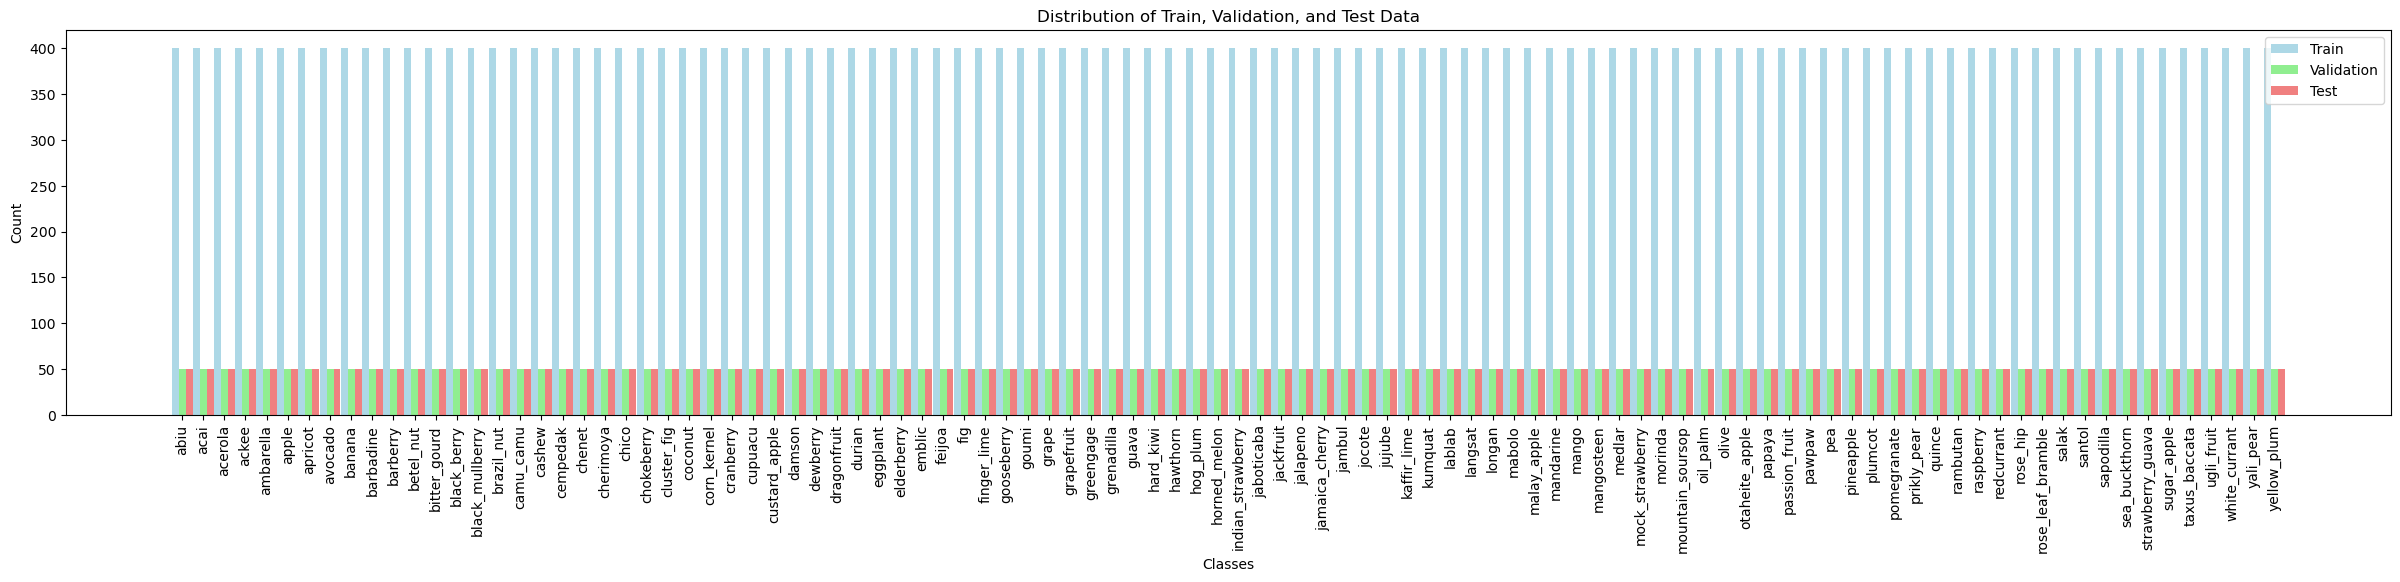

In [7]:
train_labels, train_counts = zip(*train_and_counts.items())
valid_labels, valid_counts = zip(*valid_and_counts.items())
test_labels, test_counts =   zip(*test_and_counts.items())

bar_width = 0.33
index = np.arange(len(labels))

plt.figure(figsize=(30, 5))

plt.bar(index - bar_width, train_counts, bar_width, label='Train', color='lightblue')
plt.bar(index, valid_counts, bar_width, label='Validation', color='lightgreen')
plt.bar(index + bar_width, test_counts, bar_width, label='Test', color='lightcoral')

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Train, Validation, and Test Data')
plt.xticks(index, labels, rotation=90)
plt.legend()
plt.show()

Up here as you can see that luckily each dataset has evenly distributed pictures, with the train dataset having 400 pictures of each category, and 50-50 picutres of each category in the validation and testing dataset.

I wanted to show some randomly selected pictures and their label from the training data to see how the images look.

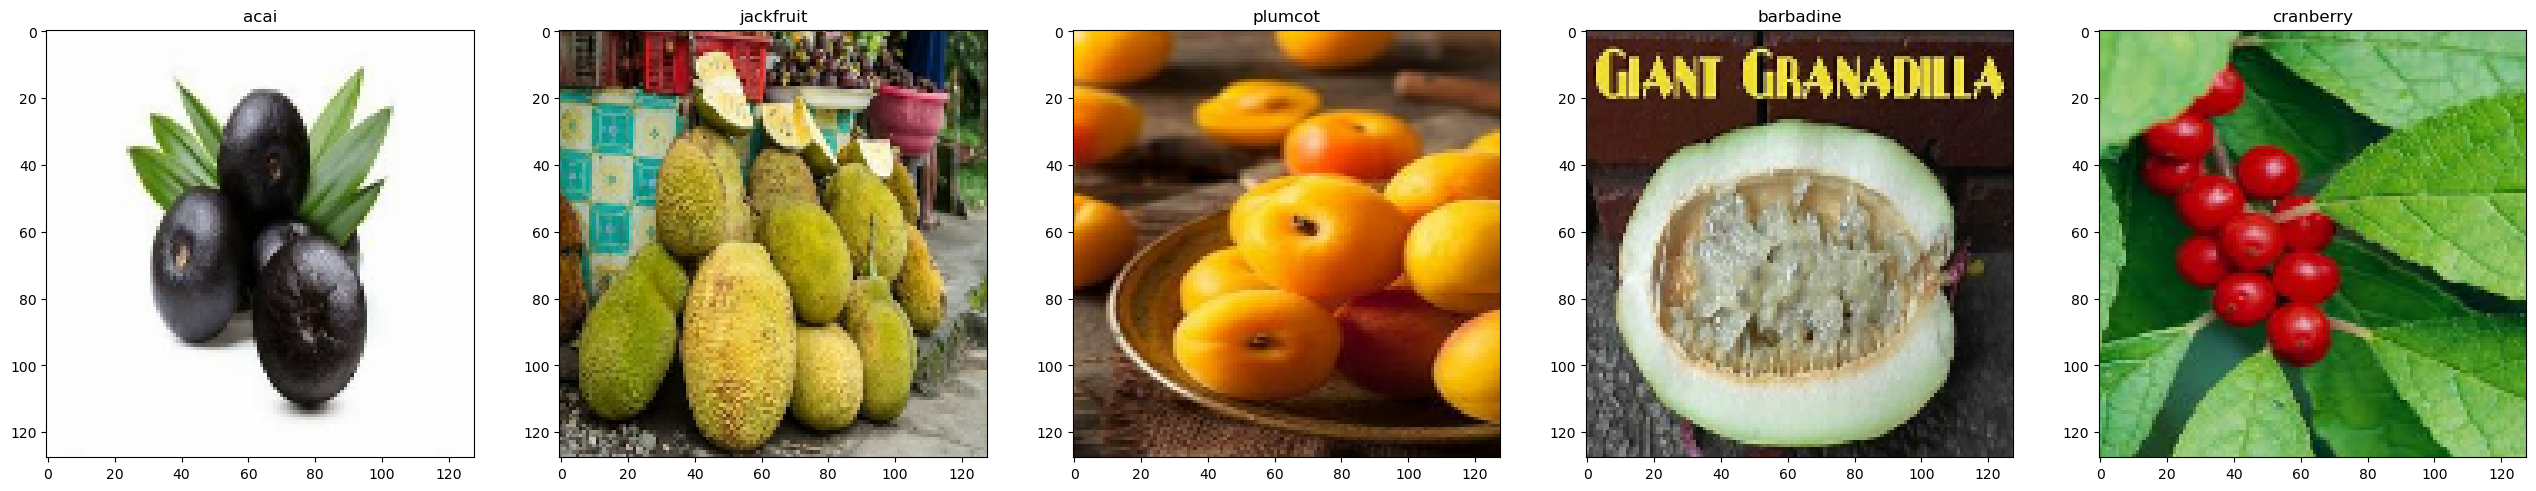

In [8]:
fig, axs_imgs = plt.subplots(1, 5, figsize=(32,32))

for imgs, labels in train.take(1):
    for i in range(5):
        axs_imgs[i].title.set_text(train.class_names[labels[i]])
        axs_imgs[i].imshow(imgs[i].numpy().astype('uint8'))
        
plt.show()

Here in my first attempt I wanted to preprocess the dataset and place them in the corresponding x and y variables, but later I just used the variables of validation, test, and train, which was enough for my work, as I've figured it out, but I didn't want to delete this cell.

But here I would append each feature and the labels to the variables, making this function reuseable for each dataset.

In [9]:
def preprocess_dataset(dataset):
    features_list = []
    labels_list = []

    for images, labels in dataset:
        features_list.append(images.numpy() / 255.0)
        labels_list.append(labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels_proc = np.concatenate(labels_list, axis=0)

    return features, labels_proc

train_x, train_y = preprocess_dataset(train)
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y.shape)

valid_x, valid_y = preprocess_dataset(validation)
print("Shape of valid_x:", valid_x.shape)
print("Shape of valid_y:", valid_y.shape)

test_x, test_y = preprocess_dataset(test)
print("Shape of test_x:", test_x.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_x: (40000, 128, 128, 3)
Shape of train_y: (40000,)
Shape of valid_x: (5000, 128, 128, 3)
Shape of valid_y: (5000,)
Shape of test_x: (5000, 128, 128, 3)
Shape of test_y: (5000,)


In [10]:
train_x[0].shape

(128, 128, 3)

As you can see above the shape of the train_x's first element is indeed 128x128 with the 3 being the RGB colors.

Down below I start to prepare the model which is a resnet50 model, which can be used for image classification. The amount of layers are the results of many tries, but this is the one that managed to get the best result based on validation loss and validation accuracy.

I gave it the input shape of the image size and the RGB values, which is the same as the above part which's shape is (128,128,3). I used Droput layers to prevent overfitting, because it prevents overfitting by ensuring that no units are codependent with one another with dropping random neurons out (in this case 50% of the neurons)

I gave it the Adam optimizer, which gave me way better results, compared to previous iterations, where I used the Stohastic Gradient Descent. It has a small learning rate, which gave me the best results based on my tries throughout my work.

In [11]:
model_resnet = Sequential()

resnet_base = ResNet50(include_top=False, input_shape=(image_size[0], image_size[1], 3), classes=100, pooling='avg', weights='imagenet')
for layer in resnet_base.layers:
    layer.trainable = False
model_resnet.add(resnet_base)

model_resnet.add(Flatten())
model_resnet.add(Dropout(0.5))

model_resnet.add(Dense(526, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(100, activation='softmax'))

model_resnet.compile(optimizer=Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I also loaded the model, to be able to demo it live, and see the results.

In [12]:
resnet_model = load_model("./model/model_resnet.hdf5",compile = False)
opt = optimizers.Adam(learning_rate=0.00001)
resnet_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

I used two callback functions, first one is the Early Stopping, which prevents the training of going way worse and still continuing for many epochs in case I am away from the computer. For this I've given it a 5 epoch patience. The second one is the Model Checkpointing, which saves the model every time it reaches a better validation loss.

In [108]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("./model/model_resnet.hdf5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
]

Down here I can start the training. I gave it 100 epochs, and a batch size of 32, which gave the best results during my work. And also giving it my callback functions for it to use.

In [110]:
history = model_resnet.fit(train, epochs=100,batch_size=32, validation_data=validation, callbacks=callbacks)

Epoch 1/100
1243/1250 [============================>.] - ETA: 0s - loss: 4.7366 - accuracy: 0.0114

KeyboardInterrupt: 

Since I've trained the model many times and on Kaggle and on my local computer as well, I've saved the historical data to a csv file to be able to visualize the process of the loss and the accuracy in a graph.

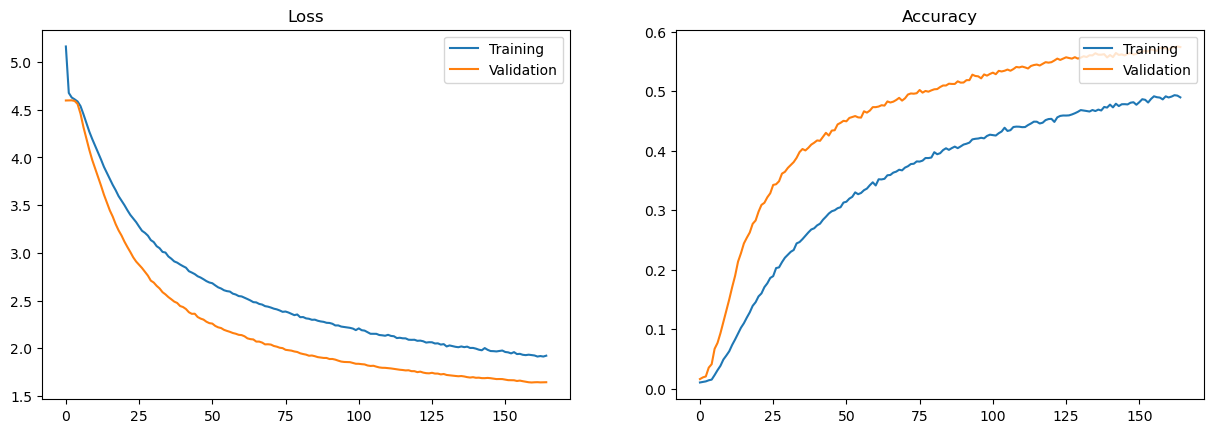

In [13]:
resnet_hist = pd.read_csv('./model/resnet_hist.csv')
fig, axs = plt.subplots(1,2)

fig.set_figwidth(15)

axs[0].set_title("Loss")
axs[0].plot(resnet_hist['loss'], label= "Training")
axs[0].plot(resnet_hist['val_loss'], label = "Validation")
axs[0].legend(loc="upper right")

axs[1].set_title("Accuracy")
axs[1].plot(resnet_hist['accuracy'], label= "Training")
axs[1].plot(resnet_hist['val_accuracy'], label = "Validation")
axs[1].legend(loc="upper right")

Up above you can see that the validation loss and the accuracy is reaching better results compared to the training, so I can confidently say that it does not have overfitting. (Although it has reached around 60% validation accuracy, other people's work had major overfitting problem. For example one had 90% training accuracy, while the validation accuracy was arouond only 15%. And some of the picture I wouldn't recognise either based on some given pictures.)

Down here I am preparing to take some randomly selected pictures from the testing dataset, and I make some prints to see each picture's label index.

In [88]:
test_images_res, test_labels_res = tuple(zip(*test.take(1)))
test_labels_res = test_labels_res[0].numpy()
test_images_res = test_images_res[0]

In [89]:
test_labels_res

array([60, 54, 84, 12, 75, 69, 47, 67, 88,  4, 56, 17, 96, 89, 87, 75, 36,
       69, 80, 35, 85, 76, 18,  9, 71,  1, 55, 69, 85, 98, 60, 88])

In [90]:
test_images_res.shape

TensorShape([32, 128, 128, 3])

Up here as you can see the shape indicates that the batch size is 32, the image size is 128x128, and has the 3 for the RGB values.

Down below here is where I  take the model to predict the test images that were randomly selected.

In [91]:
predictions_res = resnet_model.predict(test_images_res)

1/1 [==============================] - 0s 420ms/step


Down below I've written out the label of the results of the predicted values. And based on looking above some cells it does predict correctly many pictures.

In [92]:
predicted_labels_res = predictions_res.argmax(axis = 1)
predicted_labels_res

array([60,  2, 84, 12, 75, 50, 47, 37, 88, 73, 56, 17, 96, 89, 10, 75, 36,
       69,  6, 35, 84, 76, 61, 44, 71,  1, 16, 69, 85, 98, 60, 88],
      dtype=int64)

Down below I've used the same technique to show 5 images that I've used to show 5 images from the training set, with the difference of I've written out the real name, and the predicted name of the picture, as well as the confidence that it has came to.

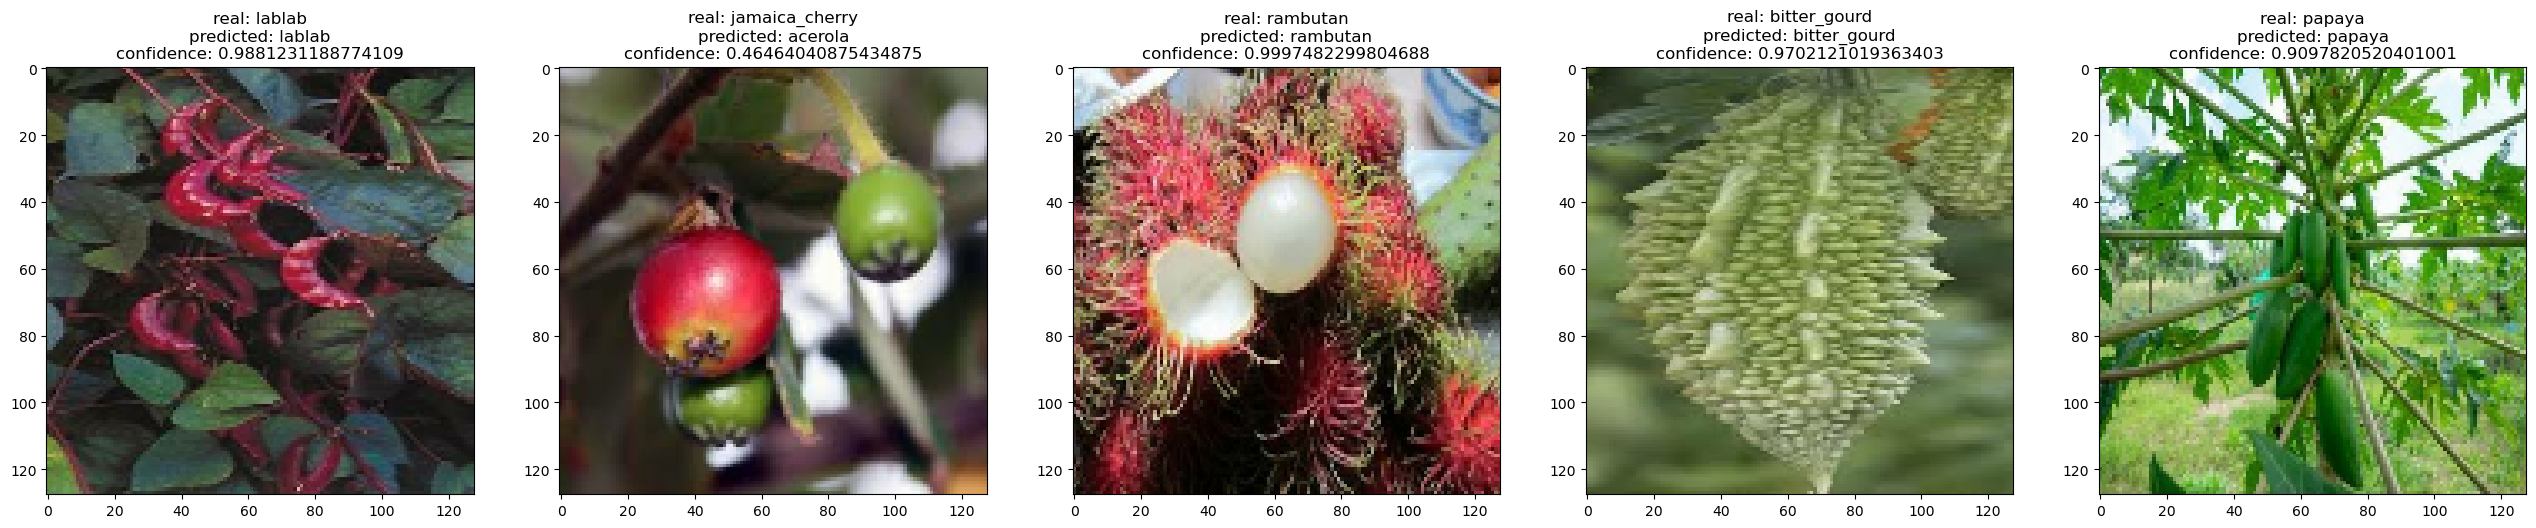

In [93]:
fig, axs_imgs = plt.subplots(1, 5, figsize=(32,32))

for i in range(5):
    confidence = predictions_res[i,predicted_labels_res[i]]
    axs_imgs[i].title.set_text(f"real: {labels[test_labels_res[i]]}\npredicted: {labels[predicted_labels_res[i]]}\nconfidence: {confidence}")
    axs_imgs[i].imshow(test_images_res[i].numpy().astype('uint8'))
        
plt.show()

As you can see above it did predict most of the images very confidentally.

In conclusion it was a very good thing to work more on these types of problems, and seeing more fruits as well that I've neven even heard of or seen before. 

I had some challanges during my work that I think I've handled well, and came to a great result with this project. Based on this semester's learned techniques I had a better understanding of how to do most of the task.

I hope you find this assignment satisfactory as a final project, as the end of the semester approaches.